In [10]:
import numpy as np
from maxvolpy.maxvol import maxvol
from numpy.polynomial import Chebyshev as T
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import lu as lu
from gen_mat import *
from block_rect_maxvol import *
import scipy.linalg
import re
%matplotlib inline

In [4]:
nder = 2 # 
expansion = 5
n = 600 # number of points
n_test = 5000 #points on test grid
p_size = (nder+1)*expansion #number of monoms (number of columns)
interval = [-1, 1]  # interval of x_test
x = 2*np.random.rand(n, nder)-1

In [5]:
c = GenMat(p_size, x,poly=cheb, poly_diff=cheb_diff, debug=False,pow_p=1)
# c = GenMat(p_size, x, poly=trigpoly, poly_diff=trigpoly_diff, debug=False, pow_p=1)
print c.shape
# turn matrix to the block structure
A = matrix_prep(c,nder+1,n)
print A.shape

(1800, 15)
(1800, 15)


### Testing the new most general environment

58
58
334
58
334
83
58
334
83
259
58
334
83
259
303
58
334
83
259
303
580
58
334
83
259
303
580
275
58
334
83
259
303
580
275
156
83
83
58
83
58
334
83
58
334
50
83
58
334
50
303
83
58
334
50
303
96
83
58
334
50
303
96
413
83
83
259
83
259
303
83
259
303
580
83
259
303
580
473
83
259
303
580
473
156


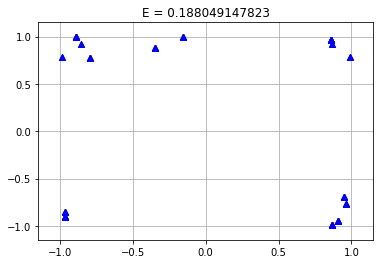

In [54]:
### generating test points
points_test = test_points_gen(n_test, nder, distrib='random') 
### evaluating test
max_row = 10
with open("func=gauss.txt","w+") as f:
    for expansion in range(1,4):
        for N_rows_ex in range(expansion, max_row):
            N_rows = N_rows_ex*(nder+1)
            error = test(A, x, points_test, nder, expansion, N_rows, gauss)
            f.write("error={}_Nrows={}_expans={}\n".format(error, N_rows, expansion))
            f.flush()

In [59]:
def file_extraction_old(Filepath):
    f = open(Filepath)
    line = f.readline()
    error, N_rows, N_col =[],[],[]
     
    while line != "":
        pos1 = line.find('error=') + len('error=')
        pos2 = line.find('_Nrows=')
        pos3 = line.find('_expans=')
        pos4 = line.find('\n')
        error.append(float(line[pos1:pos2]))
        N_rows.append(int(line[pos2+len('_Nrows='):pos3]))
        N_col.append(int(line[pos3+len('_expans=') :pos4]))
        line = f.readline()
    f.close()
    return (error, N_rows, N_col)

def file_extraction(Filepath):
    srch = re.compile(r'error=([\+\-\d\.eE]+)_Nrows=(\d+)_expans=(\d+)')
    fnd = srch.findall(open(Filepath, 'r').read())
    return tuple(np.array(i) for i in zip(*[(float(i0), int(i1), int(i2)) for i0, i1, i2 in fnd]))


def DataToMesh(error, N_row, N_col):
    row_s = sorted(list(set(N_row)))
    col_s = sorted(list(set(N_col)))
    data = {}
    for i, e in enumerate(error):
        data[(N_row[i], N_col[i])] = e
    
    res = np.empty((len(row_s), len(col_s)), dtype=float)
    for i, r in enumerate(row_s):
        for j, c in enumerate(col_s):
            try:
                res[i,j] = data[(r, c)]
            except:
                res[i,j] = np.nan
    X, Y = np.meshgrid(row_s, col_s)
    return res.T, X, Y
        
    

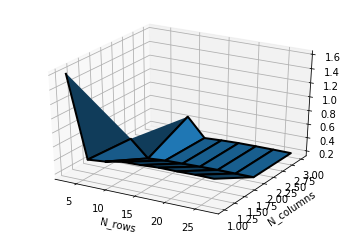

In [60]:
error, N_row, N_col = DataToMesh(*file_extraction("func=gauss.txt"))
fig = plt.figure()
ax = fig.gca(projection='3d')
# N_row, N_col = np.meshgrid(N_row, N_col)
ax.plot_surface(N_row, N_col, error, edgecolor='black', linewidth=2)
ax.legend()
ax.set_xlabel('N_rows', fontsize=10)
ax.set_ylabel('N_columns')
plt.show()

### Old computation versions

#### Information about initial matrix

In [ ]:
print la.det(A[:A.shape[1]])
print la.matrix_rank(A)
print la.matrix_rank(A[:A.shape[1]])
_,s,_ = scipy.linalg.svd(A)
print s

piv,_ = maxvol(A)
print piv
print la.det(A[piv])

In [ ]:
### returns 2 values - function on domain, and block structured
def rhs(points, nder, mode = 'gauss'):
    if mode == 'gauss':
        block_rhs = np.zeros((nder+1)*(points.shape[0]))
        func = 2*np.exp(-((points[:,0]**2)/2. + (points[:,1]**2)/2.))# + (points[:,2]**2)/2.)) # Gaussian
        for i in range(points.shape[0]):
            block_rhs[i*(nder+1)] = func[i]
            for j in range(nder):
                block_rhs[i*(nder+1)+j+1] = -1*(points[i,j])*func[i]
    if mode == '3D' :
        block_rhs = np.zeros((nder+1)*(points.shape[0]))
        func = 2*((points[:,0]**2)/2. + (points[:,1]**2)/2. + (points[:,2]**2)/2.) # Gaussian
        for i in range(points.shape[0]):
            block_rhs[i*(nder+1)] = func[i]
            for j in range(nder):
                block_rhs[i*(nder+1)+j+1] = 2 * points[i,j]
    return func, block_rhs     

#### Rectangular block maxvol

In [ ]:
k = 15 ### number of rows for LSM
assert k//(nder+1)!=0
assert (k>=A.shape[1])
a,b,final_piv,d,e = rect_block_maxvol(A, nder, Kmax = k, max_iters=100, rect_tol = 0.05, tol = 0.0, debug = False, ext_debug = True)

In [ ]:
### solve LSM
f,t = rhs(x,nder, mode = 'gauss')
A_test = GenMat(p_size, points_test,poly=cheb, debug=False,pow_p=1, ToGenDiff=False)

In [ ]:
f_test,_ = rhs(points_test,nder)

In [ ]:
### Take number of rows that we really need
c = final_piv[:k]

In [ ]:
c_block, res_x, rank, s = np.linalg.lstsq(A[c],t[c])

In [ ]:
taken_p = x[c[::(nder+1)]/(nder+1),:]

In [ ]:
# visualization part
# position of the chosen points by MaxVol and GD in 2-D case
l_bound = interval[0]
u_bound = interval[1]
plt.xlim(l_bound-0.15, u_bound+0.15)
plt.ylim(l_bound-0.15, u_bound+0.15)
#plt.plot(M[row_indx,1], M[row_indx,2], 'ro', label = "MV")
plt.plot(taken_p[:,0],taken_p[:,1], 'b^', label = "BMV")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, borderaxespad=0.)
plt.grid(True)
plt.show()

In [ ]:
print("GD error = ", la.norm(f_test - np.dot(A_test, c_block), np.inf) / la.norm(f_test, np.inf), "\n")

In [58]:
error

array([[ 3,  6,  9, 12, 15, 18, 21, 24, 27],
       [ 3,  6,  9, 12, 15, 18, 21, 24, 27],
       [ 3,  6,  9, 12, 15, 18, 21, 24, 27]])